# Swapnil_Kaner_ssk230013_Project_2_Model_Training_File

SBA_Loan_Analysis.











OBJECTIVES:

1. Train and Tune a classification model on the available data to classify non-defaulting banks from defaulting banks.
2. Get probability outputs so as to interpret the risk of defaulting on the loan associated with any case.
3. No low latency requirements, therefore we can have a good amount of features in the data space.
4. Feature importance and model interpretability is required for better understanding of the issue at hand.

# Importing the Dataset.

In [3]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import pandas as pd
from category_encoders import TargetEncoder
import re


data = pd.read_csv('./SBA_loans_project_2.csv')


# Splitting The Dataset.

The whole dataset is broken into train, test and validation datasets.

Train will be used to model the data.
Validation will be used for tuning to identify the best set of hyperparameters.
Test will be used to get the final performace for the final model.

In [4]:
temp_df, test_df = train_test_split(data, test_size=0.15, random_state=42)
train_df, validation_df = train_test_split(temp_df, test_size=0.2, random_state=42)

# Pre-processing the data.

All the relevant preprocessing will be carried out for the features.

1. Zip: Imputation of missing leading zero. Conversion to string.
2. City: All values to uppercase and removal of any non-alphabetic characters to avoid duplication. Stripping any leading or trailing spaces.
3. Bank: All values to uppercase to avoid duplication. Stripping any leading or trailing spaces.
4. FranchiseCode: Encoding to 2 if Franchise exists; 0,1 if No Franchise.
5. NewExist: Encoding to 1 if New Business; 0 otherwise.
6. For LowDoc, RevLineCr, UrbanRural, etc the data will be used in its original form.
7. For all the features, filling Na values, imputing 0 for numeric column, 'Missing' for non-numeric columns.


In [5]:
def preprocess_data(df):

    # Convert ZipCode to string and add leading zero if necessary
    df['Zip'] = df['Zip'].astype(str).apply(lambda x: x.zfill(5))

    # Convert City and Bank names to uppercase for uniformity.
    df['City'] = df['City'].str.upper().str.strip()
    df['Bank'] = df['Bank'].str.upper().str.strip()


    # Function to remove non-alphabetic characters
    def remove_non_alphabetic(text):
        # Check if the value is a string or can be converted to a string
        if isinstance(text, str):
            # Using regex to remove non-alphabetic characters
            return re.sub(r'[^a-zA-Z]', ' ', text)
        else:
            # Handle non-string values (you can choose to return None or something else as needed)
            return text

    # Apply the function to the 'City' column
    df['City'] = df['City'].apply(remove_non_alphabetic)


    # Define a function to apply the encoding to FranchiseCode
    def custom_encode(value):
        if value == 1:
            return 1
        elif value == 0:
            return 0
        else:
            return 2

    df['FranchiseCode'] = df['FranchiseCode'].apply(custom_encode)


    # Recode 'NewExist' column.
    df.loc[(df['NewExist'] == 0) | (df['NewExist'] == 1), 'NewExist'] = 0
    df.loc[(df['NewExist'] == 2), 'NewExist'] = 1


    # Fill missing values in numerical columns with 0
    numerical_cols = df.select_dtypes(include=['number']).columns
    df[numerical_cols] = df[numerical_cols].fillna(0)


    # Fill missing values in categorical columns with 'Missing'
    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('Missing')


preprocess_data(train_df)
preprocess_data(validation_df)
preprocess_data(test_df)

#  Correction of categorical feature datatype assignment.

Correcting the  datatypes for numeric categorical features to dissolve any ordinality.

In [6]:
to_categorical = ['Zip', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural']

for cols in to_categorical:
    train_df[cols] = train_df[cols].astype('object')
    validation_df[cols] = validation_df[cols].astype('object')
    test_df[cols] = test_df[cols].astype('object')

# Creating Engineered Features.

1. Bank_BankState: To single-out the statewise banking entity.
2. State_BankState_Same: 1 if the loan is issued and utilized in the same state, 0 otherwise.
3. City_State: To single-out cities that have the same names in different States.
4. Zip3, Zip4: To capture the information and trends in a wider geographic region.
5. DisbursementGross_minus_GrAppv: To get the additional amount that was Disbursed than the approved amount.
6. DisbursementGross_minus_SBA_Appv: To get the additional amount that was Disbursed than the SBA approved amount.
7. GrAppv_minus_SBA_Appv: To get the difference in the total Approved Amount and SBA Approved Amount.
8. NoEmp_minus_RetainedJob: To get the amount of people that were downsized during the duration of the loan.

Note: 3 more features are created in the next section.

In [7]:
def featurize_data(df):

    # Create a new feature 'Bank_BankState' to identify each State-wise entity of the bank.
    df['Bank_BankState'] = df['Bank']+'_'+df['BankState']

    # Create a new feature 'State_BankState_Same' which has a value of 1 if 'State' and 'BankState' are the same, otherwise 0
    df['State_BankState_Same'] = (df['State'] == df['BankState']).astype(int)

    # Create a new feature 'City_State' to identify each City State-wise.
    df['City_State'] = df['City']+'_'+df['State']

    # Extract first four and three digits of Zip to separate out different geographical sections.
    df['Zip3'] = df['Zip'].str[:3]
    df['Zip4'] = df['Zip'].str[:4]

    # Create a new feature 'DisbursementGross_minus_GrAppv' to get the additional amount that was Disbursed than the approved amount.
    df['DisbursementGross_minus_GrAppv'] = df['DisbursementGross']-df['GrAppv']

    # Create a new feature 'DisbursementGross_minus_SBA_Appv' to get the additional amount that was Disbursed than the SBA approved amount.
    df['DisbursementGross_minus_SBA_Appv'] = df['DisbursementGross']-df['SBA_Appv']

    # Create a new feature 'GrAppv_minus_SBA_Appv' to get the difference in the total Approved Amount and SBA Approved Amount .
    df['GrAppv_minus_SBA_Appv'] = df['GrAppv']-df['SBA_Appv']

    # Create a new feature 'NoEmp_minus_RetainedJob' to get the amount of people that were downsized during the duration of the loan.
    df['NoEmp_minus_RetainedJob'] = df['NoEmp']-df['RetainedJob']


featurize_data(train_df)
featurize_data(validation_df)
featurize_data(test_df)

# Target Encoding.

1. Bank_BankState is target encoded to capture the Global default rate for the Banks.
2. NAICS is target encoded to capture the Global default rate for the each subsection of the economy.

In [8]:
columns_to_trg_encode = ['Bank_BankState', "NAICS"]
categorical_encoders = {}

for col in columns_to_trg_encode:
    print(col)
    trg_encoder = TargetEncoder()

    trg_encoder.fit(train_df[col],train_df.MIS_Status)

    train_df[col + '_trg'] = trg_encoder.transform(train_df[col])
    validation_df[col + '_trg'] = trg_encoder.transform(validation_df[col])
    test_df[col + '_trg'] = trg_encoder.transform(test_df[col])

    categorical_encoders[(col, "trg")] = trg_encoder

Bank_BankState
NAICS


# Numerical Feature Binning

NoEmp, CreateJob and Retained Job are binned to allow the model to identify any macro level trends in these features.

In [9]:
bin_edges_dict = {}

def bin_numerical_columns(numerical_cols, train_df, validation_df, test_df, bins):
    for col in numerical_cols:
        # Bin the train dataframe
        train_df[f'{col}_binned'], bin_edges = pd.qcut(train_df[col], q=bins, labels=False, retbins=True, duplicates='drop')
        bin_edges_dict[(col, "bin_edge")] = bin_edges

        # Handle outliers in validation and test datasets
        validation_df[f'{col}_binned'] = pd.cut(validation_df[col], bins=bin_edges, labels=False, include_lowest=True)
        test_df[f'{col}_binned'] = pd.cut(test_df[col], bins=bin_edges, labels=False, include_lowest=True)

        # Replace NaNs for out of bounds values
        validation_df[f'{col}_binned'] = validation_df[f'{col}_binned'].fillna(bins - 1).astype(int)
        test_df[f'{col}_binned'] = test_df[f'{col}_binned'].fillna(bins - 1).astype(int)

numerical_cols_to_cat = ["NoEmp", "CreateJob", "RetainedJob"]

bin_numerical_columns(numerical_cols_to_cat, train_df, validation_df, test_df, bins=50)

# Launching an H2O instance.

In [8]:
import h2o
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch

h2o.init(max_mem_size = "250G", nthreads= -1)             #specify max number of bytes. uses all cores by default.
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpqm9p1wiv
  JVM stdout: /tmp/tmpqm9p1wiv/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpqm9p1wiv/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,7 months and 15 days
H2O_cluster_name:,H2O_from_python_unknownUser_k3y4vk
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,250 Gb
H2O_cluster_total_cores:,96
H2O_cluster_allowed_cores:,96
H2O_cluster_status:,"locked, healthy"


# Importing Dataframes to H20 Dataframes.

In [11]:
h2o_train_df = h2o.H2OFrame(train_df)
h2o_validation_df = h2o.H2OFrame(validation_df)
h2o_test_df = h2o.H2OFrame(test_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


#  Correction of categorical feature datatype assignment.

Correcting the  datatypes for numeric categorical features to dissolve any ordinality.

In [12]:
numerical_to_categorical = ['Zip', 'NAICS', 'NewExist', 'FranchiseCode', 'UrbanRural', 'RevLineCr', 'State_BankState_Same', 'MIS_Status']

for cols in numerical_to_categorical:
    h2o_train_df[cols] = h2o_train_df[cols].asfactor()
    h2o_validation_df[cols] = h2o_validation_df[cols].asfactor()
    h2o_test_df[cols] = h2o_test_df[cols].asfactor()


# Checking the impact of feature engineering efforts.

In [22]:
cols_X = ['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
        'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
col_Y = 'MIS_Status'  

In [23]:
base_model = H2OGradientBoostingEstimator()

base_model.train(x=cols_X, y = col_Y, training_frame = h2o_train_df, validation_frame = h2o_validation_df )

print('Model performance with no feature engineering:', base_model.model_performance(h2o_test_df).auc())

gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
Model performance with no feature engineering: 0.8117608980895509


# Including Engineered features with base model. 

In [24]:
cols_X = h2o_train_df.columns  # Get all columns
col_Y = 'MIS_Status'           # Define the target column
cols_to_remove = ['MIS_Status', 'index']  # List of columns to remove

cols_X = list(filter(lambda col: col not in cols_to_remove, cols_X))

In [25]:
base_model2 = H2OGradientBoostingEstimator()

base_model2.train(x=cols_X, y = col_Y, training_frame = h2o_train_df, validation_frame = h2o_validation_df )

print('Model performance with Engineered features:', base_model2.model_performance(h2o_test_df).auc())

gbm Model Build progress: |

██████████████████████████████████████████████████████| (done) 100%
Model performance with Engineered features: 0.8281606997469615


The engineered features were able to boost the model AUC ROC performance by almost 0.12.

Further hyperparameter tuning can increase this AUC ROC.

In [12]:
h2o_train_df

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned
183603,BALTIMORE,MD,21216,BANK OF AMERICA NATL ASSOC,NC,445310,1,0,0,0,1,1,Y,N,25000,0,25000,12500,1,BANK OF AMERICA NATL ASSOC_NC,0,BALTIMORE_MD,212,2121,0,12500,12500,1,0.329436,0.125931,0,0,0
198356,BAY SHORE,NY,11706,JPMORGAN CHASE BANK NATL ASSOC,IL,531210,1,0,0,1,1,1,Y,N,231603,0,100000,50000,0,JPMORGAN CHASE BANK NATL ASSOC_IL,0,BAY SHORE_NY,117,1170,131603,181603,50000,0,0.28046,0.399143,0,0,0
773135,BLANDON,PA,19510,NATIONAL PENN BANK,PA,811118,1,0,0,1,0,2,N,N,180000,0,180000,135000,0,NATIONAL PENN BANK_PA,1,BLANDON_PA,195,1951,0,45000,45000,0,0.0776471,0.156832,0,0,0
723404,GREEN COVE SPRINGS,FL,32043,"TD BANK, NATIONAL ASSOCIATION",FL,541330,3,0,0,0,1,2,N,N,422000,0,422000,316500,0,"TD BANK, NATIONAL ASSOCIATION_FL",1,GREEN COVE SPRINGS_FL,320,3204,0,105500,105500,3,0.122222,0.0919927,2,0,0
113065,NORTH CHARLESTON,SC,29406,BUSINESS DEVEL CORP OF SO. CAR,SC,621210,1,0,0,0,1,0,N,N,200000,0,200000,150000,0,BUSINESS DEVEL CORP OF SO. CAR_SC,1,NORTH CHARLESTON_SC,294,2940,0,50000,50000,1,0.174825,0.0408805,0,0,0
127062,EDISON,NJ,8817,BANK OF AMERICA NATL ASSOC,RI,811113,5,0,0,0,1,0,N,N,550000,0,550000,467500,0,BANK OF AMERICA NATL ASSOC_RI,0,EDISON_NJ,88,881,0,82500,82500,5,0.118813,0.216296,4,0,0
113602,GRANDVIEW,MO,64030,CAPITAL ONE NATL ASSOC,VA,484210,15,0,5,15,1,1,,N,50000,0,50000,25000,0,CAPITAL ONE NATL ASSOC_VA,0,GRANDVIEW_MO,640,6403,0,25000,25000,0,0.419394,0.22871,13,4,11
381697,COLUMBUS,OH,43229,"PNC BANK, NATIONAL ASSOCIATION",OH,722410,5,1,0,0,1,0,N,N,65000,0,65000,58500,0,"PNC BANK, NATIONAL ASSOCIATION_OH",1,COLUMBUS_OH,432,4322,0,6500,6500,5,0.0268371,0.142545,4,0,0
398569,BELTSVILLE,MD,20705,MANUFACTURERS & TRADERS TR CO,MD,0,10,0,0,0,1,0,N,Y,100000,0,100000,80000,0,MANUFACTURERS & TRADERS TR CO_MD,1,BELTSVILLE_MD,207,2070,0,20000,20000,10,0.058634,0.0831211,9,0,0
354110,BRISTOL,CT,6101,WEBSTER BANK NATL ASSOC,CT,236118,2,0,2,2,0,1,Y,N,142401,0,50000,25000,1,WEBSTER BANK NATL ASSOC_CT,1,BRISTOL_CT,61,610,92401,117401,25000,0,0.09125,0.412868,1,1,1


# Hyperparameter Grid creation and Training H2O GBM model.

In [13]:
# create hyperameter and search criteria lists (ranges are inclusive..exclusive))
hyper_params_tune = {'max_depth' : [6,8,10,12,13,14],
                'sample_rate': [x/100. for x in range(50,101)],
                'col_sample_rate' : [x/100. for x in range(50,101)],
                'col_sample_rate_per_tree': [x/100. for x in range(50,101)],
                'col_sample_rate_change_per_level': [x/100. for x in range(90,111)],
                'min_rows': [2**x for x in range(0,8)],
                'nbins': [2**x for x in range(4,11)],
                'nbins_cats': [2**x for x in range(4,11)],
                'min_split_improvement': [0,1e-8,1e-6,1e-4],
                'histogram_type': ["UniformAdaptive","QuantilesGlobal","RoundRobin"]}
search_criteria_tune = {'strategy': "RandomDiscrete",
                   'max_models': 60,
                   'seed' : 12,
                   'stopping_rounds' : 10,
                   'stopping_metric' : "AUC",
                   'stopping_tolerance': 1e-4
                   }

In [14]:
gbm_grid = H2OGradientBoostingEstimator(distribution='bernoulli',
                    ## more trees is better if the learning rate is small enough
                    ## here, use "more than enough" trees - we have early stopping
                    ntrees=1000,
                    ## smaller learning rate is better
                    ## since we have learning_rate_annealing, we can afford to start with a
                    #bigger learning rate
                    learn_rate=0.05,
                    ## learning rate annealing: learning_rate shrinks by 1% after every tree
                    ## (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    ## score every 10 trees to make early stopping reproducible
                    #(it depends on the scoring interval)
                    score_tree_interval = 10,
                    ## fix a random number generator seed for reproducibility
                    seed = 12,
                    ## early stopping once the validation AUC doesn't improve by at least 0.01% for
                    #5 consecutive scoring events
                    stopping_rounds = 10,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4)

#Build grid search
tuning_grid = H2OGridSearch(gbm_grid, hyper_params = hyper_params_tune,
                                    grid_id = 'tuning_grid',
                                    search_criteria = search_criteria_tune)
#Train grid search
tuning_grid.train(x=cols_X,
           y=col_Y,
           training_frame = h2o_train_df,
           validation_frame = h2o_validation_df)

gbm Grid Build progress: |███████████████████████████████████████████████████████| 100%e) 100%


,col_sample_rate,col_sample_rate_change_per_level,col_sample_rate_per_tree,histogram_type,max_depth,min_rows,min_split_improvement,nbins,nbins_cats,sample_rate,model_ids,logloss
,0.54,1.05,0.6,UniformAdaptive,14.0,16.0,1e-08,1024.0,512.0,0.72,tuning_grid_model_51,0.3352985
,0.59,1.0,0.76,RoundRobin,13.0,8.0,1e-06,256.0,512.0,0.96,tuning_grid_model_21,0.3353046
,0.61,1.01,0.68,QuantilesGlobal,13.0,2.0,1e-08,1024.0,256.0,0.87,tuning_grid_model_16,0.3354320
,0.87,0.97,0.76,QuantilesGlobal,14.0,32.0,1e-08,128.0,1024.0,0.79,tuning_grid_model_37,0.3356853
,0.77,0.93,0.66,QuantilesGlobal,13.0,8.0,1e-08,256.0,128.0,0.78,tuning_grid_model_54,0.3356959
,0.67,1.0,0.55,RoundRobin,14.0,16.0,0.0001,512.0,1024.0,0.76,tuning_grid_model_44,0.3360216
,0.64,0.96,0.7,QuantilesGlobal,14.0,2.0,1e-06,1024.0,512.0,0.84,tuning_grid_model_50,0.3361316
,0.59,1.07,0.59,QuantilesGlobal,12.0,64.0,0.0,256.0,1024.0,0.63,tuning_grid_model_30,0.3362501
,0.77,1.08,0.88,RoundRobin,14.0,64.0,1e-08,512.0,512.0,0.74,tuning_grid_model_24,0.3362546
,0.71,1.0,0.66,QuantilesGlobal,13.0,4.0,1e-08,32.0,16.0,0.71,tuning_grid_model_10,0.3362754


In [15]:
## Sort the grid models by AUC
sorted_tuning_grid = tuning_grid.get_grid(sort_by='auc',decreasing=True)
print(sorted_tuning_grid)

Hyper-Parameter Search Summary: ordered by decreasing auc
     col_sample_rate    col_sample_rate_change_per_level    col_sample_rate_per_tree    histogram_type    max_depth    min_rows    min_split_improvement    nbins    nbins_cats    sample_rate    model_ids             auc
---  -----------------  ----------------------------------  --------------------------  ----------------  -----------  ----------  -----------------------  -------  ------------  -------------  --------------------  ------------------
     0.54               1.05                                0.6                         UniformAdaptive   14.0         16.0        1e-08                    1024.0   512.0         0.72           tuning_grid_model_51  0.8495039544836119
     0.87               0.97                                0.76                        QuantilesGlobal   14.0         32.0        1e-08                    128.0    1024.0        0.79           tuning_grid_model_37  0.8490833888087853
     0.59        

# Best Model Parameters.

The best model that we found has the following parameters:
1. Max_Depth: 14
2. sample_rate: 0.72
3. col_sample_rate: 0.54
4. col_sample_rate_per tree: 0.6
5. col_sample_rate_change_per_level: 1.05

And gives us an AUC of 0.8495 on the Validation dataset.

Given that our data has a moderate number of features, some with very high cardinality, the depth of 14 for the best model seems reasonable.

In [16]:
best_model = h2o.get_model(sorted_tuning_grid.sorted_metric_table()['model_ids'][0])
performance_best_model = best_model.model_performance(h2o_test_df)
print("Best Grid Model AUC on Test:",performance_best_model.auc())

conf_matrix = performance_best_model.confusion_matrix()
print(conf_matrix)

Best Grid Model AUC on Test: 0.8501363496808743
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2521235831838291
       0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      85535  13409  0.1355   (13409.0/98944.0)
1      7549   13411  0.3602   (7549.0/20960.0)
Total  93084  26820  0.1748   (20958.0/119904.0)


In [14]:
h2o_threshold = performance_best_model.find_threshold_by_max_metric("f1")
h2o_threshold

0.25743623359658263

# Model Results on Test Dataset

The best GBM model has a pretty decent AUC of 0.85 on the Test Dataset. With the maxF1 threshold of 0.252, we are able to get an error rate of 0.1748.

According to our requirements, we can furthur tweak the threshold to have even more sensitivity to the defaulting observations.
The predictions made by this model can be very well utilized to flag any new loan applications that may have a high chance of default.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

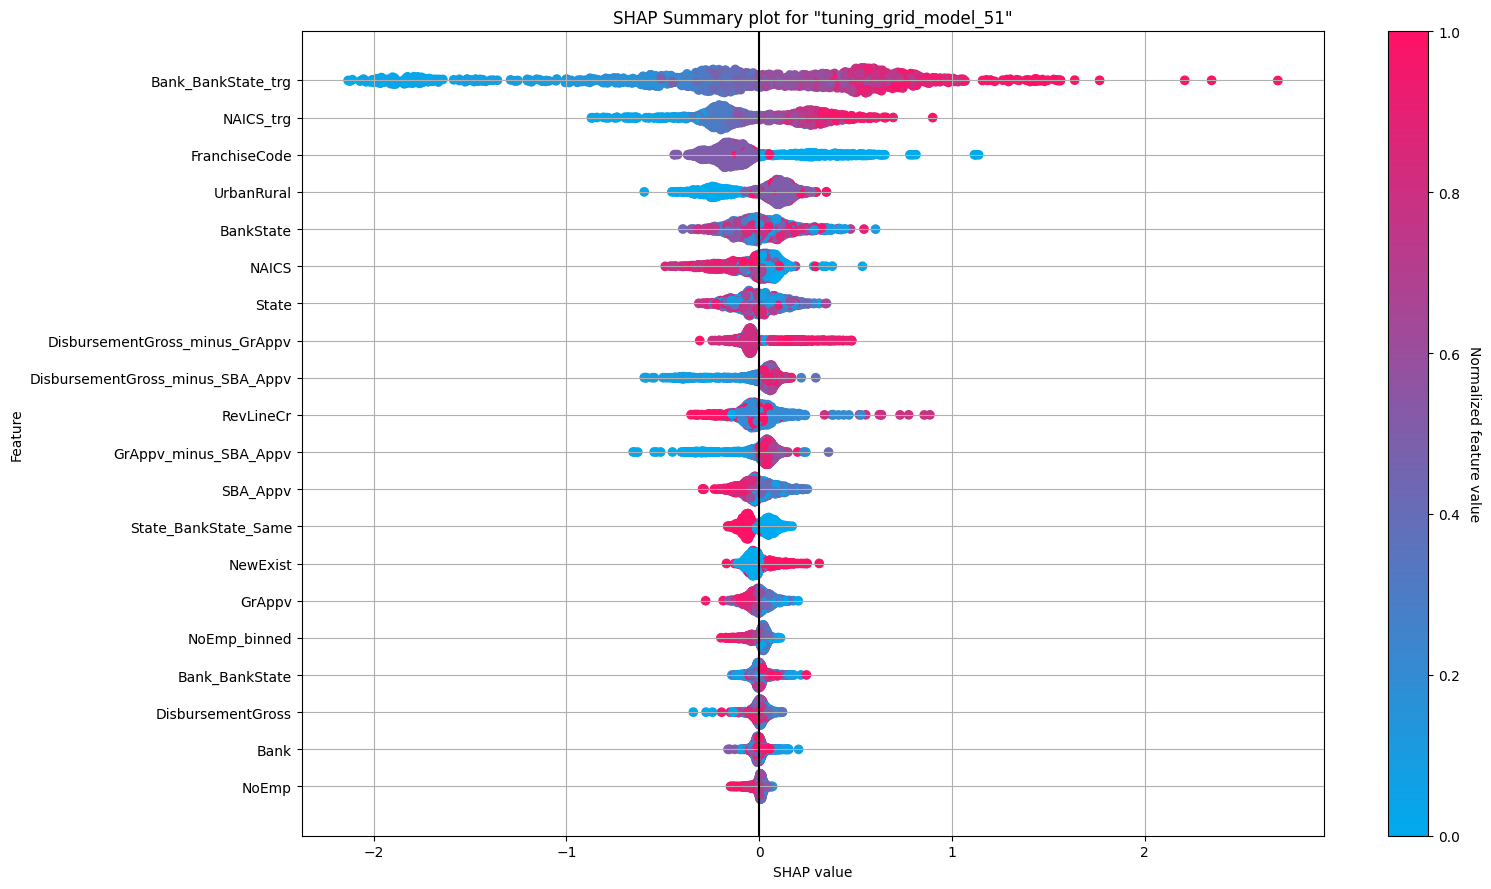

In [22]:
best_model.explain(h2o_test_df,include_explanations =['shap_summary']);

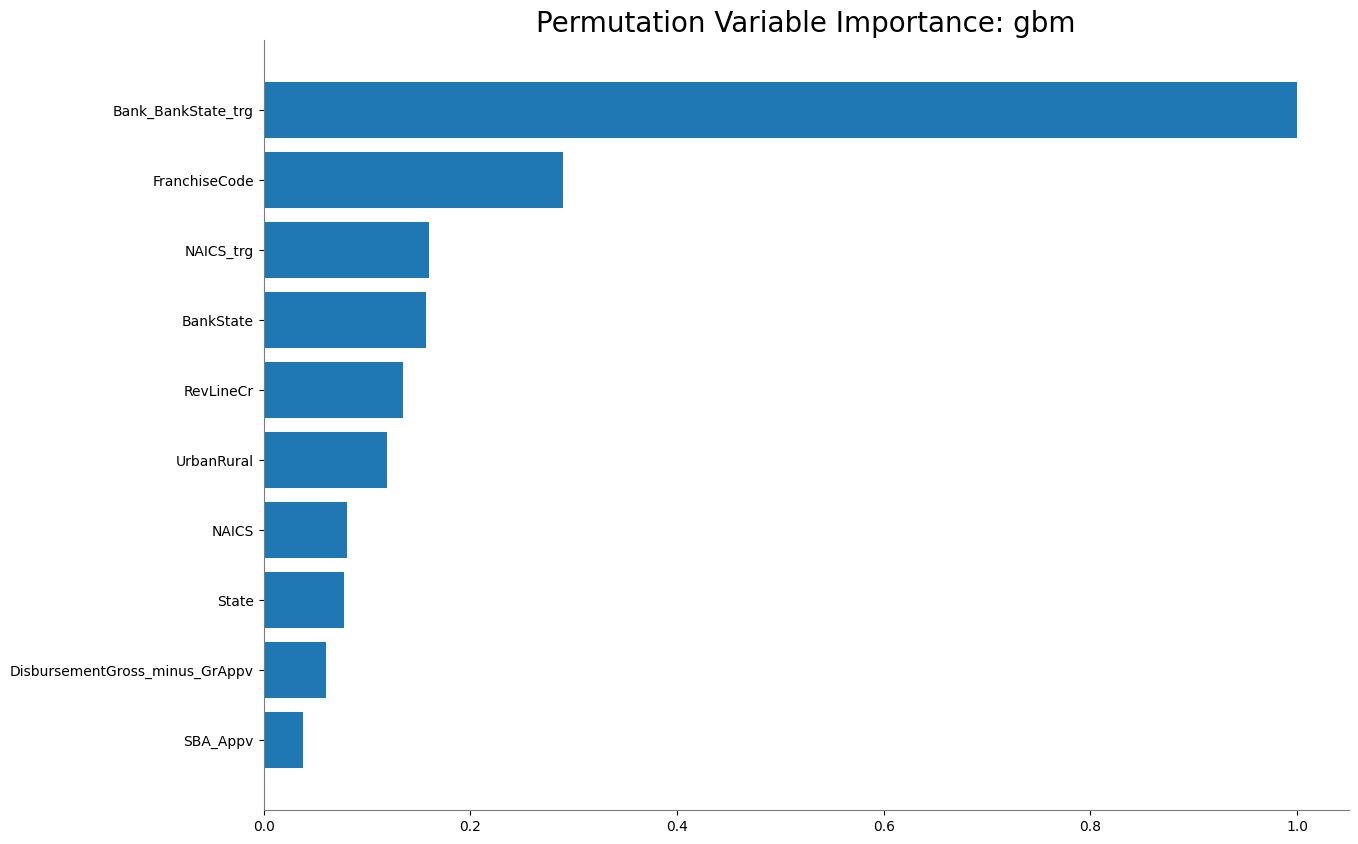

In [23]:
# plot permutation importance (bar plot)
best_model.permutation_importance_plot(h2o_test_df);

In [24]:
# calculate importance
permutation_varimp = best_model.permutation_importance(h2o_test_df, use_pandas=False)

permutation_varimp

Variable,Relative Importance,Scaled Importance,Percentage
Bank_BankState_trg,0.1417817,1.0,0.4637300
FranchiseCode,0.0408829,0.2883511,0.1337171
NAICS_trg,0.0199109,0.1404333,0.0651232
RevLineCr,0.0151703,0.1069977,0.0496180
BankState,0.0151464,0.1068293,0.0495399
UrbanRural,0.0132619,0.0935375,0.0433761
State,0.0112430,0.0792981,0.0367729
DisbursementGross_minus_GrAppv,0.0090589,0.0638933,0.0296293
NAICS,0.0066399,0.0468322,0.0217175
SBA_Appv,0.0047180,0.0332764,0.0154313


# Global Feature Importance Summary

The top features identified by Permutation Feature importance and Global Shapley summary plot are very similar.

The most important features are:

1. Bank_BankState_trg: This is the mean target encoded representation of the Bank_BankState column. A very high importance of this feature signifies that there are banks that tend to offer risky loans and then there are banks that are quite conservative when issuing loans. This points us to furthur investigate and compare the banks that generally have a high default rate and banks that have a low default rate on a fundamental level i.e. the type of customers they serve, business model, etc. The target encoded representation of a feature being so crucial, also tells us that the global characteristics of the feature are also very relevant at deeper levels of the model, where the data is segregated based on other features.
2. NAICS_trg: This is the mean target encoded representation of the NAICS column. A great relevance for this feature shows that a few sectors of the market tend to generally have a high default rate i.e. these kinds of businesses are quite unstable.
3. UrbanRural: The feature UrbanRural shows the location of the business. According to the shapley value plots, businesses in an Urban or Rural setting are most prone to a default. Whereas, when the UrbanRural location is 'undefined', the chances of deafult decreases. We will have to further investigate the businesses in the 'Undefined' category.  T
4. FranchiseCode: The FranchiseCode has a value of 0,1 if the business has a franchise, 2 otherwise. What we see from the Shap summary plot is that businesses that are spanned over more franchises generally have a lower default rate. This may be due to the fact that businesses with franchise generally tend to be more stable and established.
5. DisbursementGross_minus_SBA_Appv: This feature shows us the difference between the actual loan amount that was disbursed and the SBA approved amount. From the shapley summary plot, it is evident that loans that were partially backed by SBA generally tend to have a higher deafult chance. And loans that were fully endorsed by SBA, generally have a lower default chances.

# Residual Analysis.


In [26]:
# Predict the probabilities using the trained GBM model
predictions = best_model.predict(h2o_test_df)

predicted_probabilities = predictions["p1"].asnumeric()


h2o_test_df_sorted = h2o.H2OFrame(h2o_test_df)
h2o_test_df_sorted["MIS_Status"] = h2o_test_df_sorted["MIS_Status"].asnumeric()
h2o_test_df_sorted["p1"] = predicted_probabilities

# Step 1: Create the 's' column and set its value based on the condition
h2o_test_df_sorted['s'] = (h2o_test_df_sorted['MIS_Status'] == 0).ifelse(-1, 1)

# Step 2: Calculate the deviance residuals
h2o_test_df_sorted['r_MIS_Status'] = h2o_test_df_sorted['s'] * (
    (-2 * (h2o_test_df_sorted[col_Y] * h2o_test_df_sorted['p1'].log() +
          (1 - h2o_test_df_sorted[col_Y]) * (1 - h2o_test_df_sorted['p1']).log())).sqrt()
)

# Step 3: Drop the temporary column 's'
h2o_test_df_sorted = h2o_test_df_sorted.drop('s')

# Display the resulting H2O frame (optional)
h2o_test_df_sorted.head()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


c:\Users\skane\virtualenvn\ml-summer-2024\lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'City' has levels not trained on: ["          BOSTON POST ROAD", "        TH PL SE", "     BEVERLY BLVD", "     ELKTON DR ", "     S     W", "     SUNSET DRIVE", "    EAST THIRD STREET", "   NIXON LANE", "   PALMS", " ACKSONVILLE", ...1546 not listed..., "WOODY CREEK", "WORMLEYSBURGQ", "WRIGHTVILLE BEACH", "WYCOFF", "WYSOX", "YCCA VALLEY", "YELLOWSTONE", "YONYES ISLAND", "ZIM", "ZUNI"]
  warnings.warn(w)
c:\Users\skane\virtualenvn\ml-summer-2024\lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset column 'Zip' has levels not trained on: ["182", "345", "465", "934", "1017", "1084", "1114", "1142", "1180", "1366", ...1576 not listed..., "99132", "99139", "99173", "99363", "99553", "99612", "99624", "99703", "99765", "99923"]
  warnings.warn(w)
c:\Users\skane\virtualenvn\ml-summer-2024\lib\site-packages\h2o\job.py:81: UserWarning: Test/Validation dataset 

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned,p1,r_MIS_Status
146781,EAST WILTON,ME,4234,"TD BANK, NATIONAL ASSOCIATION",DE,621210,7,0,0,7,0,2,N,N,150000,0,150200,112650,0,"TD BANK, NATIONAL ASSOCIATION_DE",0,EAST WILTON_ME,42,423,-200,37350,37550,0,0.165119,0.0408805,6,0,6,0.0222876,-0.212319
16516,REDWAY,CA,95660,NORTH VALLEY BANK,CA,454110,18,0,0,0,1,0,N,N,410000,0,410000,307500,0,NORTH VALLEY BANK_CA,1,REDWAY_CA,956,9566,0,102500,102500,18,0.0765306,0.0621469,15,0,0,0.0220965,-0.211397
553496,CORTLAND,NY,13045,MANUFACTURERS & TRADERS TR CO,NY,0,150,1,0,0,1,0,N,N,270000,0,270000,186300,0,MANUFACTURERS & TRADERS TR CO_NY,1,CORTLAND_NY,130,1304,0,83700,83700,150,0.145633,0.0831211,22,0,0,0.101016,-0.461499
452771,YONKERS,NY,10704,CAPITAL ONE NATL ASSOC,VA,238190,7,0,0,7,1,1,,N,35000,0,35000,17500,1,CAPITAL ONE NATL ASSOC_VA,0,YONKERS_NY,107,1070,0,17500,17500,0,0.419394,0.286802,6,0,6,0.363207,1.42322
785759,LEAGUE CITY,TX,77574,PEARLAND STATE BANK,TX,0,8,0,0,0,1,0,N,Y,65000,0,65000,53950,0,PEARLAND STATE BANK_TX,1,LEAGUE CITY_TX,775,7757,0,11050,11050,8,0.130999,0.0831211,7,0,0,0.0510717,-0.323796
3064,PEMBERTON,NJ,8068,HOPEWELL VALLEY COMMUNITY BANK,NJ,238320,7,0,0,0,1,1,,Y,75000,0,75000,63750,0,HOPEWELL VALLEY COMMUNITY BANK_NJ,1,PEMBERTON_NJ,80,806,0,11250,11250,7,0.0868731,0.359142,6,0,0,0.0843682,-0.41986
37528,TIJERAS,NM,87059,WELLS FARGO BANK NATL ASSOC,SD,624410,11,0,0,0,1,0,,N,117500,0,117500,88125,1,WELLS FARGO BANK NATL ASSOC_SD,0,TIJERAS_NM,870,8705,0,29375,29375,11,0.179625,0.124464,10,0,0,0.0438176,2.50109
669456,CAPE CORAL,FL,33990,CAPITAL ONE NATL ASSOC,VA,424210,3,0,0,3,1,1,,N,25000,0,25000,12500,0,CAPITAL ONE NATL ASSOC_VA,0,CAPE CORAL_FL,339,3399,0,12500,12500,0,0.419394,0.400576,2,0,2,0.328395,-0.892284
136805,FRESNO,CA,93703,FIRST-CITIZENS BK & TR CO,NC,621111,3,0,0,0,1,1,N,N,364730,0,473400,355050,0,FIRST-CITIZENS BK & TR CO_NC,0,FRESNO_CA,937,9370,-108670,9680,118350,3,0.0786611,0.0782288,2,0,0,0.0397835,-0.284944
470791,MAYWOOD,IL,60153,INLAND BANK & TRUST,IL,484121,45,0,0,0,1,1,N,N,1.82e+06,0,1.82e+06,982800,0,INLAND BANK & TRUST_IL,1,MAYWOOD_IL,601,6015,0,837200,837200,45,0.305149,0.288791,20,0,0,0.248692,-0.756226


### The dataset is sorted in based on the deviance residual values.

In [27]:
h2o_test_df_sorted = h2o_test_df_sorted.sort('r_MIS_Status', ascending=False)

# Top Two correctly classified observations where No Default.

In [28]:
h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].head(2)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned,p1,r_MIS_Status
234097,BELTON,MO,64012,"RURAL MISSOURI, INC.",MO,0,18,1,18,0,0,0,N,N,297000,0,297000,297000,0,"RURAL MISSOURI, INC._MO",1,BELTON_MO,640,6401,0,0,0,18,0,0.0831211,15,8,0,0.00181556,-0.0602861
219557,CHARDON,OH,44022,GROWTH CAPITAL CORP.,OH,0,55,1,55,0,0,0,N,N,187000,0,187000,187000,0,GROWTH CAPITAL CORP._OH,1,CHARDON_OH,440,4402,0,0,0,55,1.1887e-07,0.0831211,21,9,0,0.00182656,-0.0604687


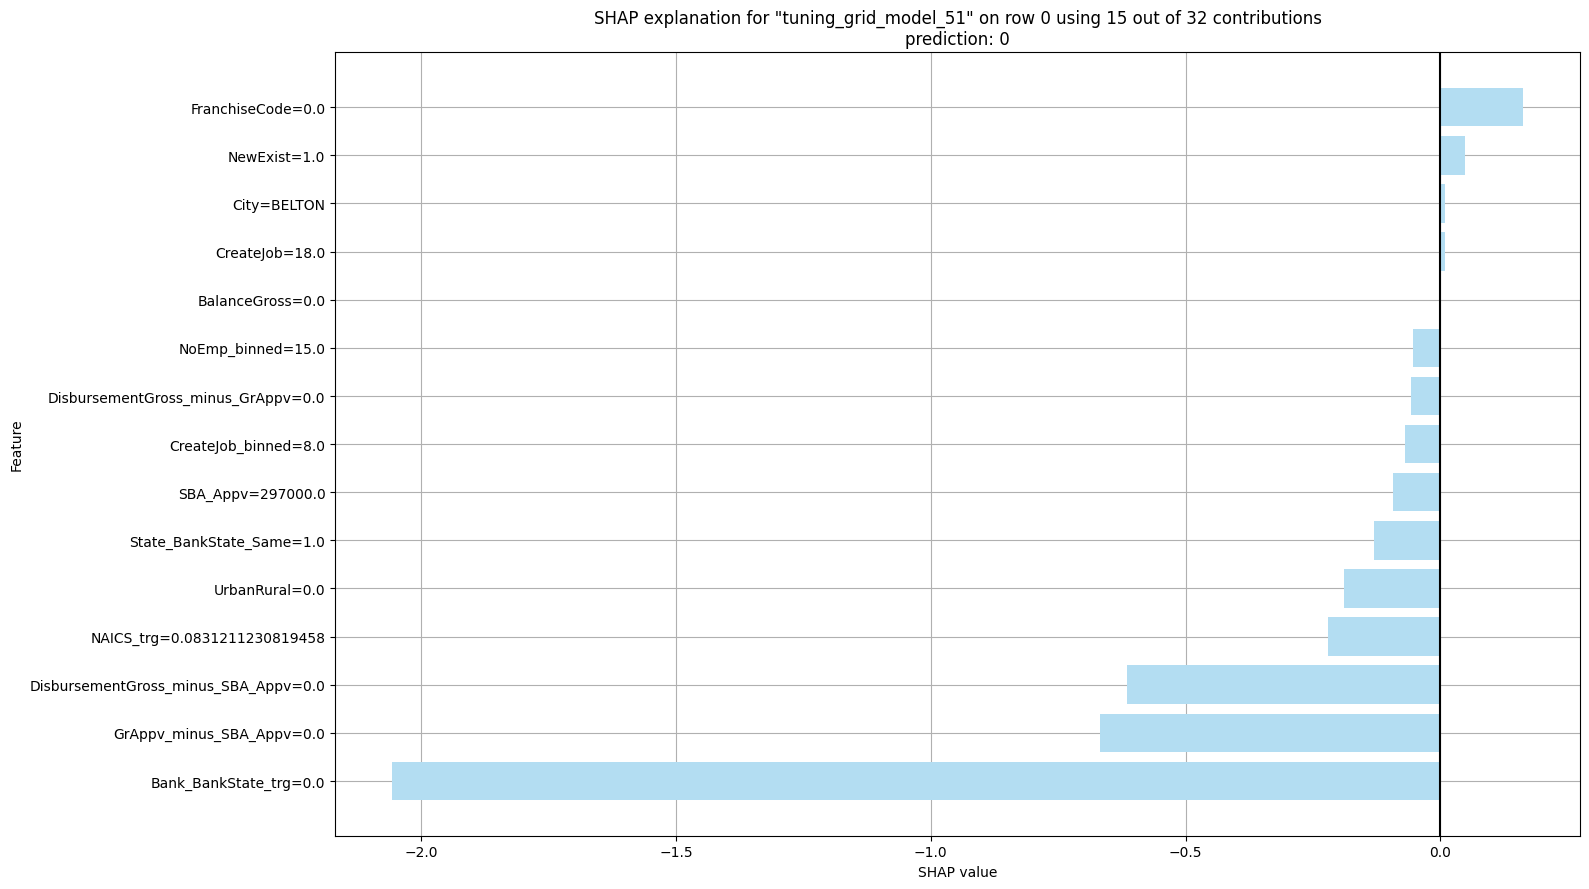

In [172]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].head(2), row_index=0);

For this observation which was very correctly identified by the model,
1. Bank_BankState_trg = 0
2. DisbursementGross_minus_SBA_Appv = 0
3. GrAppv_minus_SBA_Appv = 0

are the contributing features that lower the probability of default.

All the three features have a value of 0. The loan issuing bank 'RURAL MISSOURI, INC._MO' has a very low proportion of defaulting observations in the data. Also, the loan amount that was Approved, Disbursed and SBA endorsed was same.


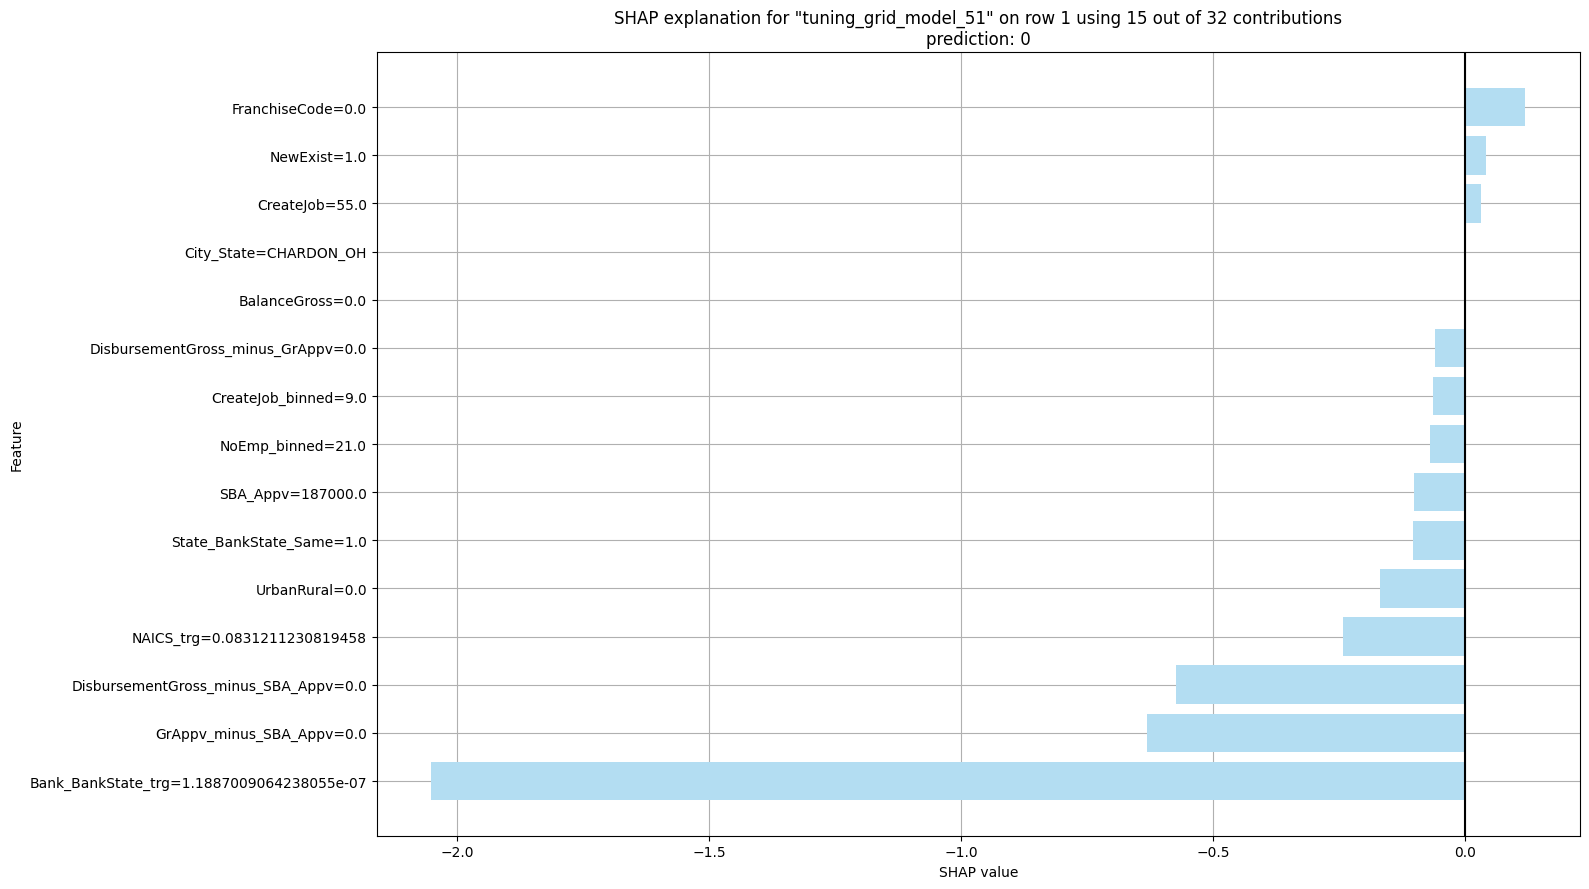

In [173]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].head(2), row_index=1)

For this observation which was very correctly identified by the model,
1. Bank_BankState_trg = 1.1887e-07
2. DisbursementGross_minus_SBA_Appv = 0
3. GrAppv_minus_SBA_Appv = 0

are the contributing features that lower the probability of default.

All the three features have a value very close to 0. The loan issuing bank 'GROWTH CAPITAL CORP._OH	' has a very low proportion of defaulting observations in the data. Also, the loan amount that was Approved, Disbursed and SBA endorsed was same.


# Top Two correctly classified observations where Default.

In [175]:
h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].tail(2)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned,p1,r_MIS_Status
295528,MANDEVILLE,LA,70448,FEDERAL DEPOSIT INSUR CORP (CA,LA,0,17,1,0,0,0,0,N,N,550000,0,550000,495000,1,FEDERAL DEPOSIT INSUR CORP (CA_LA,1,MANDEVILLE_LA,704,7044,0,55000,55000,17,0.281995,0.0831211,15,0,0,0.980446,0.198737
246284,SAN ANTONIO,TX,78216,FDIC/CAPITAL BANK NORTHWEST,TX,0,1,1,8800,8800,0,0,N,N,52500,0,52500,47250,1,FDIC/CAPITAL BANK NORTHWEST_TX,1,SAN ANTONIO_TX,782,7821,0,5250,5250,-8799,0.281995,0.0831211,0,9,14,0.985312,0.172027


### Shapley value analysis for these individual observations.

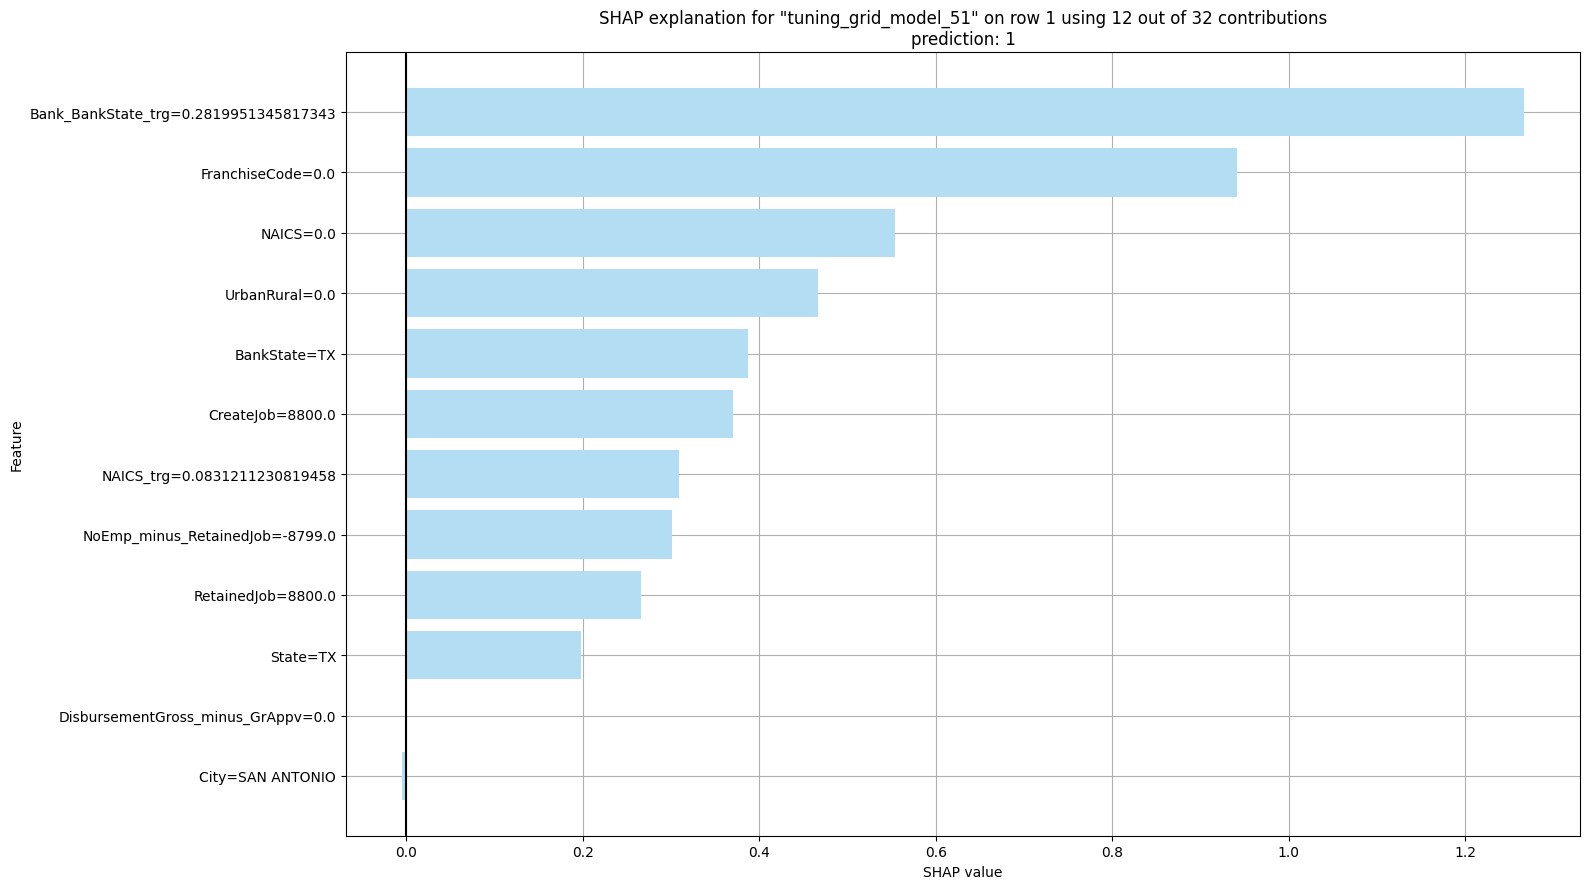

In [186]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].tail(2), row_index=1)

For this observation which was very correctly identified by the model,
1. Bank_BankState_trg = 0.282
2. FranchiseCode= 0
3. NAICS = 0
4. UrbanRural = 0

are the contributing features that increase the probability of default.

The loan issuing bank 'FDIC/CAPITAL BANK NORTHWEST_TX' has a considerably high proportion of defaulting observations in the data.

FranchiseCode is 0, which means that this business has no franchise, which is again a red flag.

NAICS is Unknown and UrbanRural is Undefined, which further increases uncertainty makes the loan default more probable.

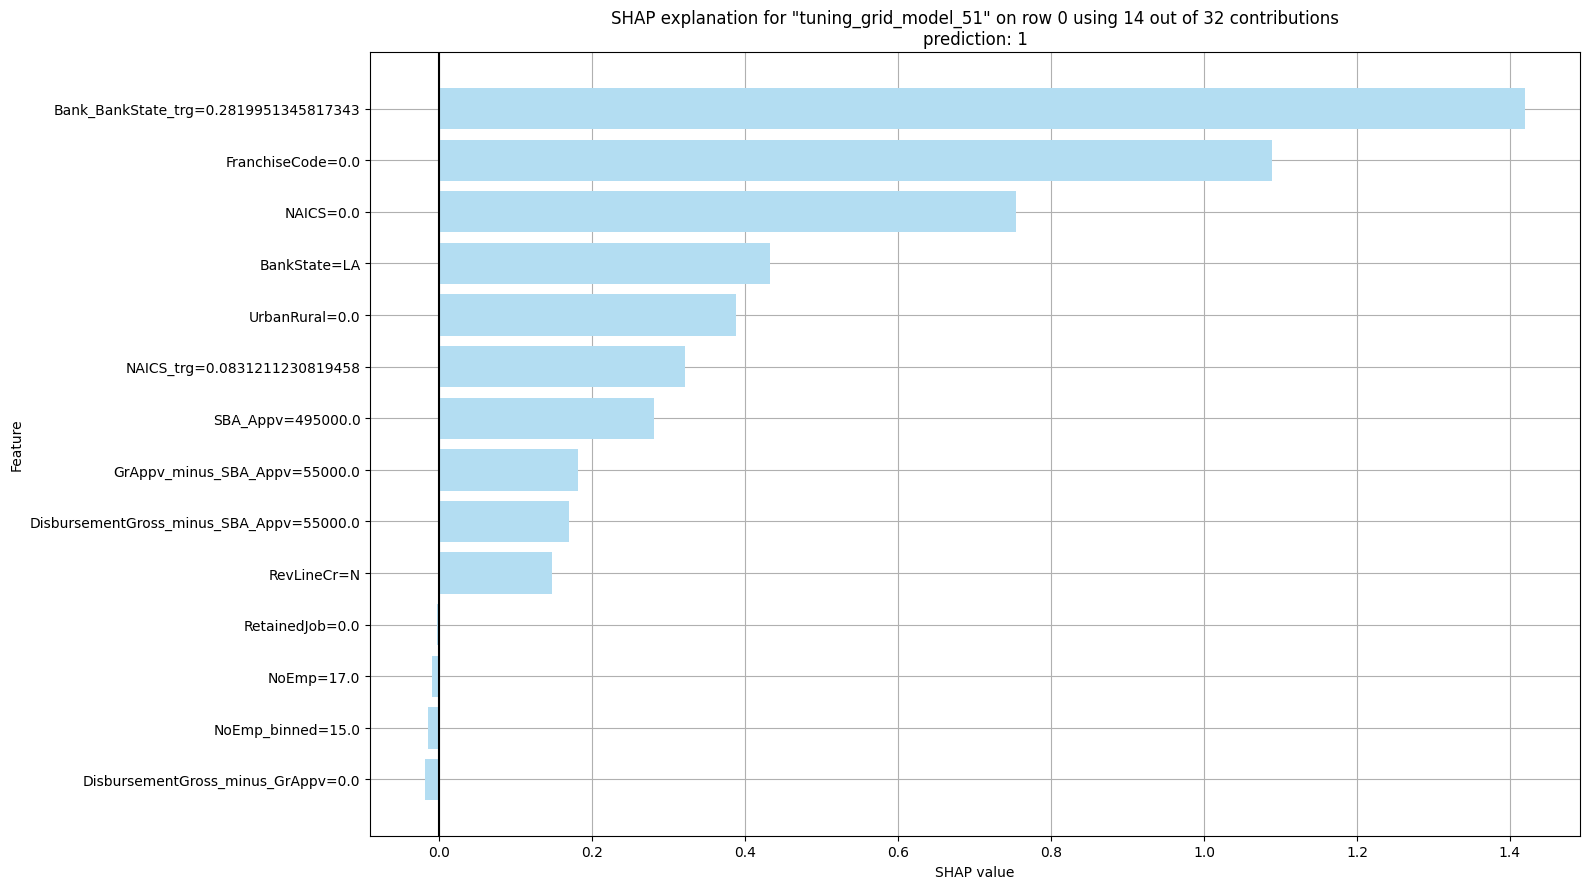

In [187]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].tail(2), row_index=0)

For this observation which was very correctly identified by the model,
1. Bank_BankState_trg = 0.282
2. FranchiseCode= 0
3. NAICS = 0

are the contributing features that increase the probability of default.

The loan issuing bank 'FEDERAL DEPOSIT INSUR CORP (CA_LA' has a considerably high proportion of defaulting observations in the data.

FranchiseCode is 0, which means that this business has no franchise, which is again a red flag.

NAICS is Unknown which further increases uncertainty makes the loan default more probable.

# Top Two incorrectly classified observations where actually No Default.

In [178]:
h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].tail(2)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned,p1,r_MIS_Status
208088,NEW CITY,NY,10956,JPMORGAN CHASE BANK NATL ASSOC,OH,0,18,0,0,0,0,0,N,N,300000,0,300000,270000,0,JPMORGAN CHASE BANK NATL ASSOC_OH,0,NEW CITY_NY,109,1095,0,30000,30000,18,0.353333,0.0831211,15,0,0,0.930453,-2.309
390035,COLUMBIA,IL,62236,CAPITAL ONE BK (USA) NATL ASSO,VA,236115,4,0,0,4,0,1,Y,N,128324,0,50000,25000,0,CAPITAL ONE BK (USA) NATL ASSO_VA,0,COLUMBIA_IL,622,6223,78324,103324,25000,0,0.864542,0.388652,3,0,3,0.950039,-2.44807


### Shapley value analysis for these individual observations.

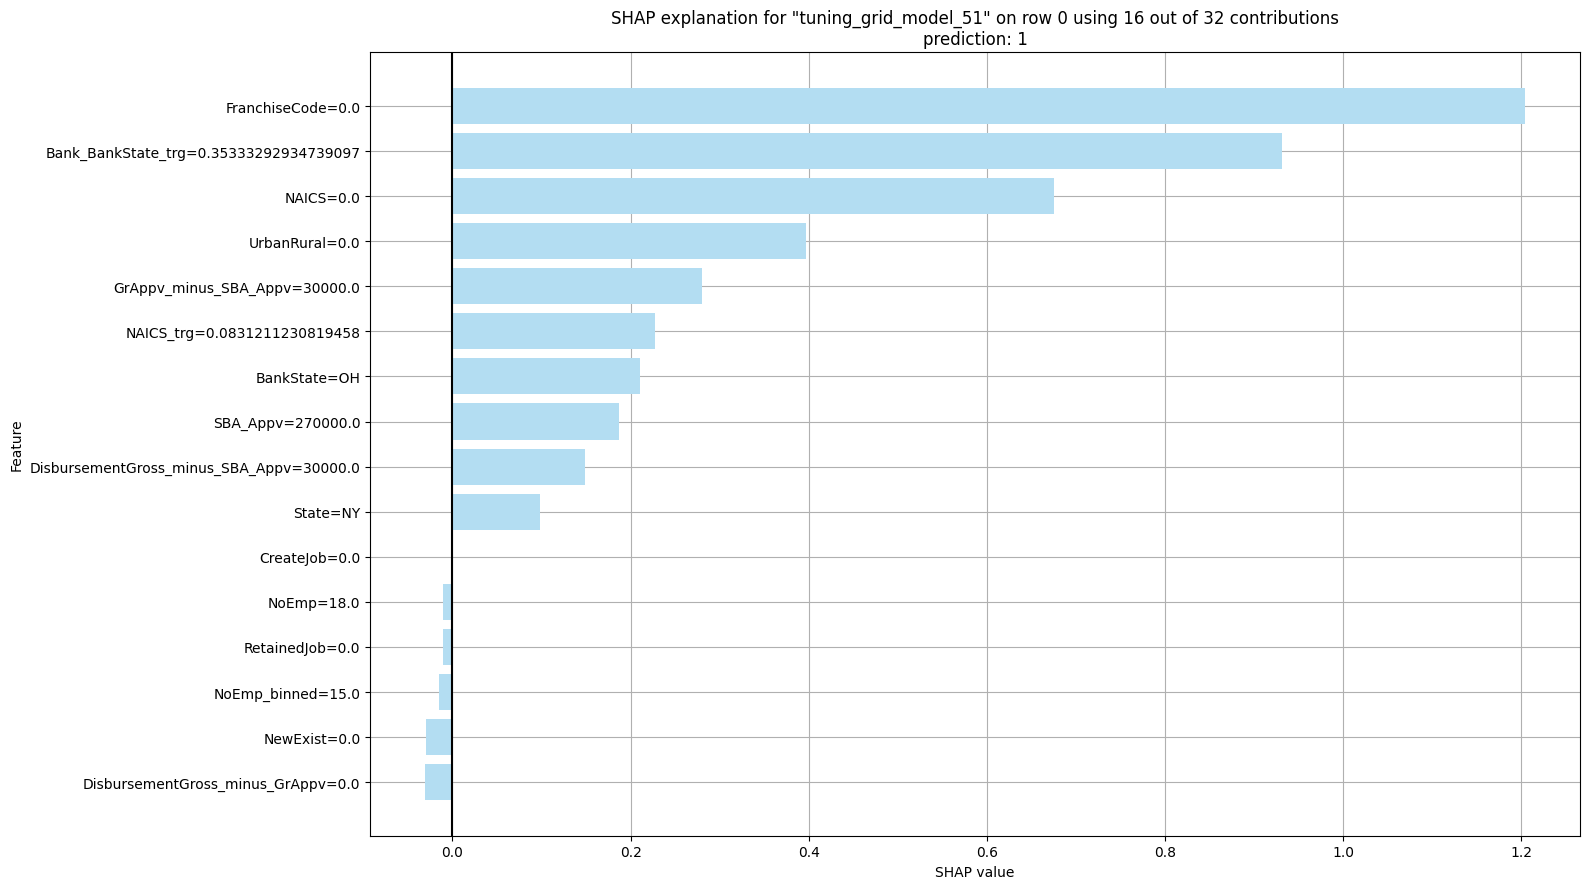

In [179]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].tail(2), row_index=0);

For this observation which was incorrectly identified by the model,

1. FranchiseCode= 0
2. Bank_BankState_trg = 0.3533
3. NAICS = 0

are the contributing features that increase the probability of default.

FranchiseCode is 0, which means that this business has no franchise, which is a huge red flag.

The loan issuing bank 'PMORGAN CHASE BANK NATL ASSOC_OH' has a considerably high proportion of defaulting observations in the data.

NAICS is Unknown which further increases uncertainty and hence made the model to prdict the default as more probable.

BUT, this case seems to be a exception to the trends that were identified by our model.

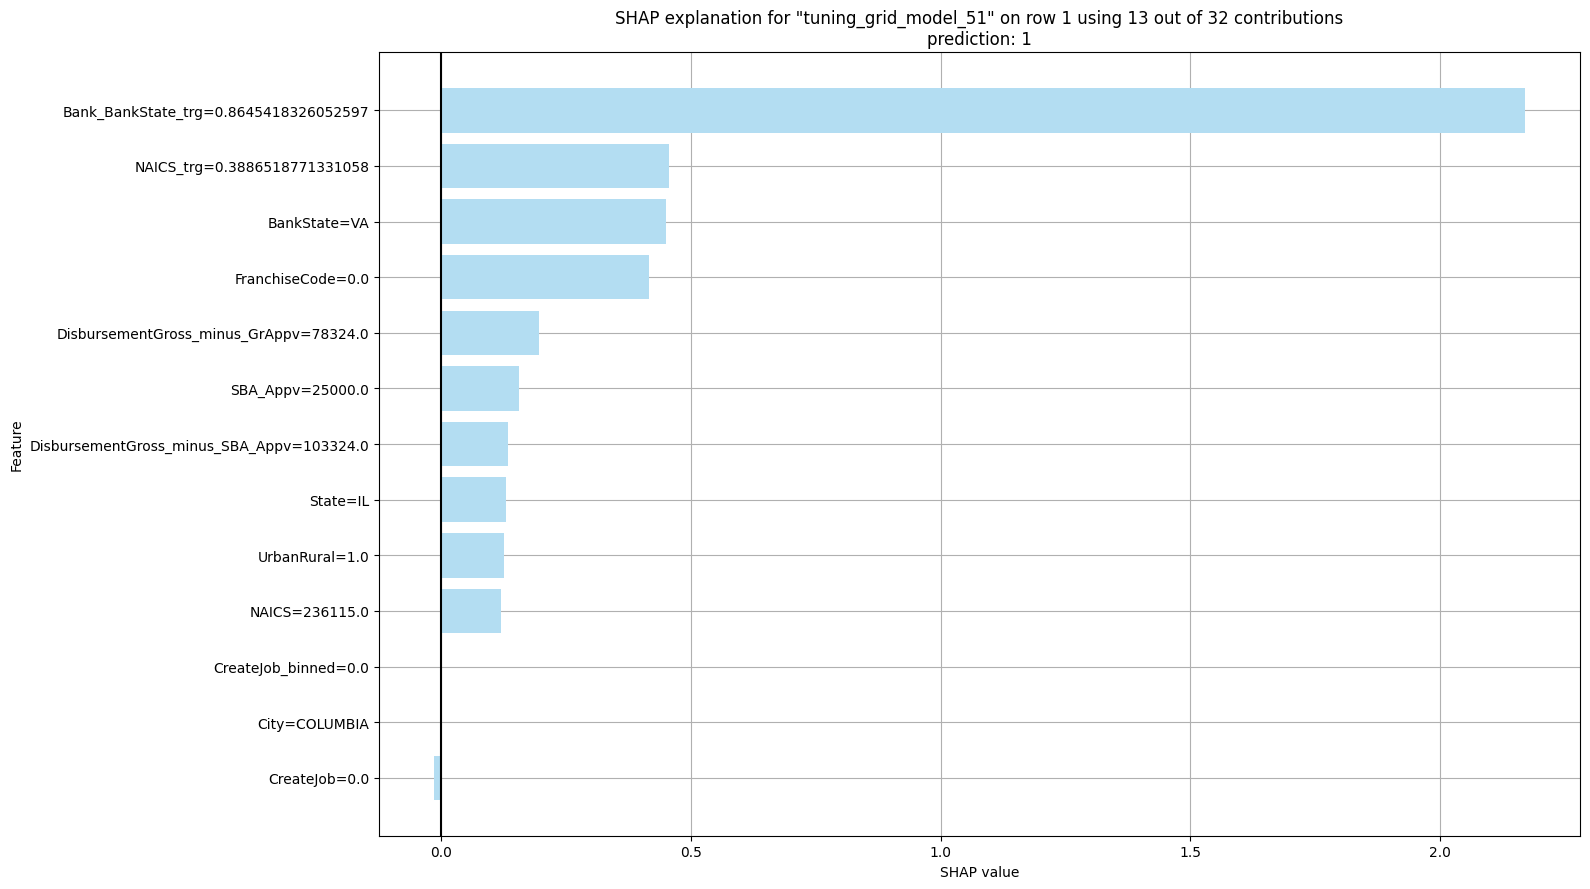

In [180]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].tail(2), row_index=1);

For this observation which was incorrectly identified by the model,

1. Bank_BankState_trg = 0.864
2. NAICS_trg = 0.388

are the contributing features that increase the probability of default.

The loan issuing bank 'CAPITAL ONE BK (USA) NATL ASSO_VA' has an exceptionally high proportion of defaulting observations in the data.

NAICS_trg is also high which further made the model to increase the probablility a default.

BUT, despite being in a risky sector and from a risky bank, this case seems to be a exception to the trends that were identified by our model.

# Top Two incorrectly classified observations where actually Default.

In [181]:
h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].head(2)

index,City,State,Zip,Bank,BankState,NAICS,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status,Bank_BankState,State_BankState_Same,City_State,Zip3,Zip4,DisbursementGross_minus_GrAppv,DisbursementGross_minus_SBA_Appv,GrAppv_minus_SBA_Appv,NoEmp_minus_RetainedJob,Bank_BankState_trg,NAICS_trg,NoEmp_binned,CreateJob_binned,RetainedJob_binned,p1,r_MIS_Status
270957,LAWRENCE,MA,1841,SANTANDER BANK NATL ASSOC,MA,235930,4,0,0,0,1,2,,Y,25000,0,25000,21250,1,SANTANDER BANK NATL ASSOC_MA,1,LAWRENCE_MA,18,184,0,3750,3750,4,0.0021322,0.0759259,3,0,0,0.00716271,3.14289
488635,BAZINE,KS,67516,CONWAY BANK NATL ASSOC,KS,115113,1,0,0,0,1,0,N,N,133200,0,178200,145411,1,CONWAY BANK NATL ASSOC_KS,1,BAZINE_KS,675,6751,-45000,-12211,32789,1,0.0150572,0.075528,0,0,0,0.00737653,3.13351


### Shapley value analysis for these individual observations.

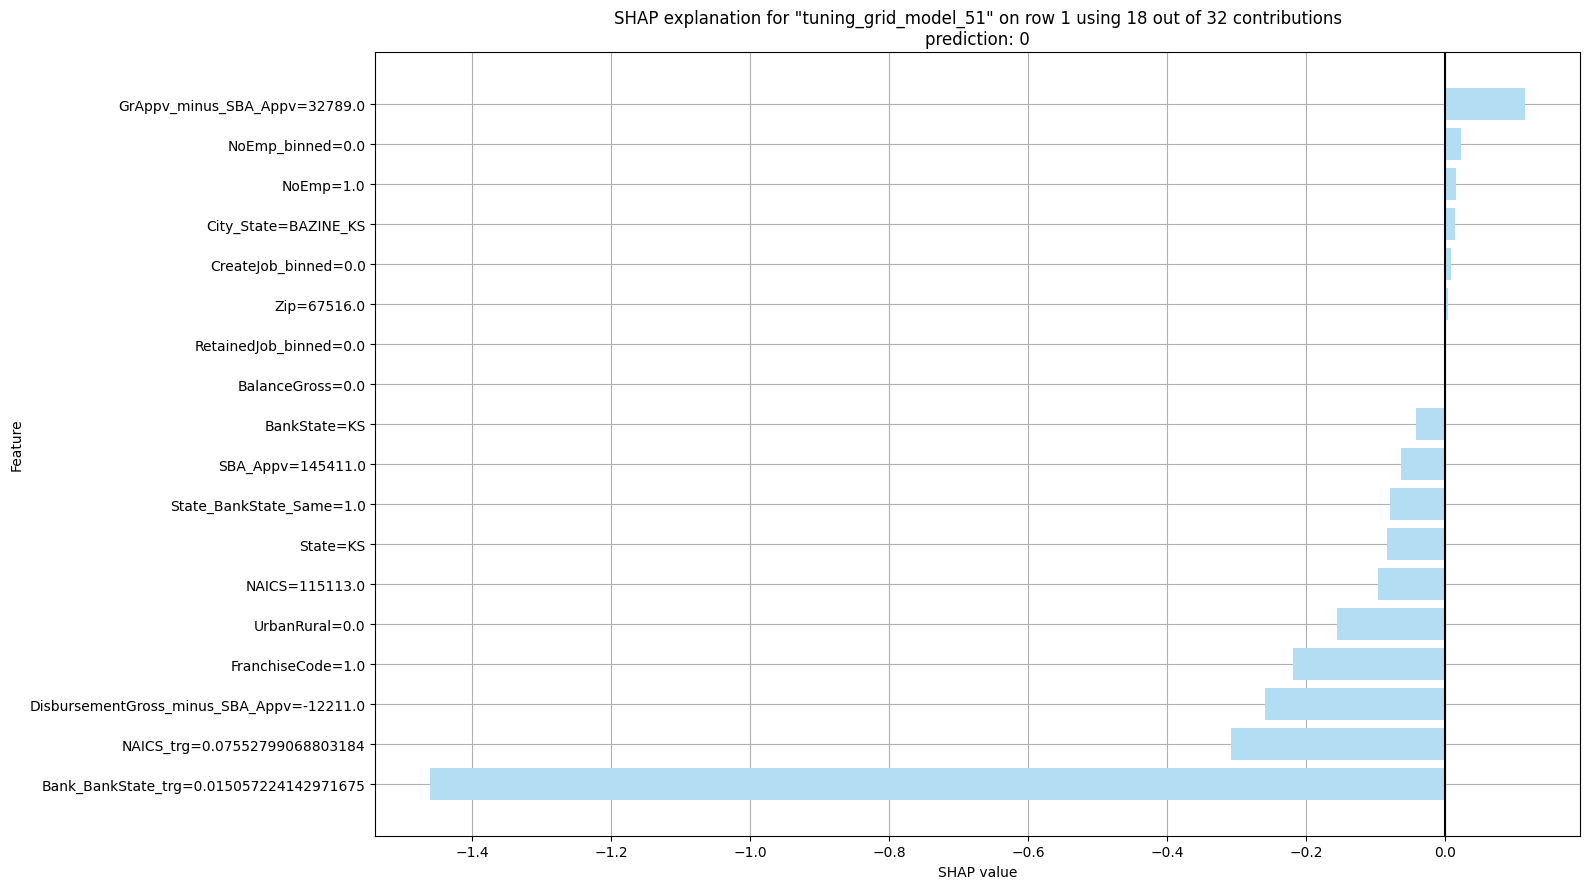

In [188]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].head(2), row_index=1);

For this observation which was incorrectly identified by the model,

1. Bank_BankState_trg = 0.015
2. NAICS_trg = 0.0755

are the contributing features that lowered the probability of default.

The loan issuing bank 'CONWAY BANK NATL ASSOC_KS' has a very good track record.

NAICS_trg is also low, which further made the model to lower the probablility of a default.

BUT, this case seems to be a exception to the trends that were identified by our model, and the loan was actually deafulted.

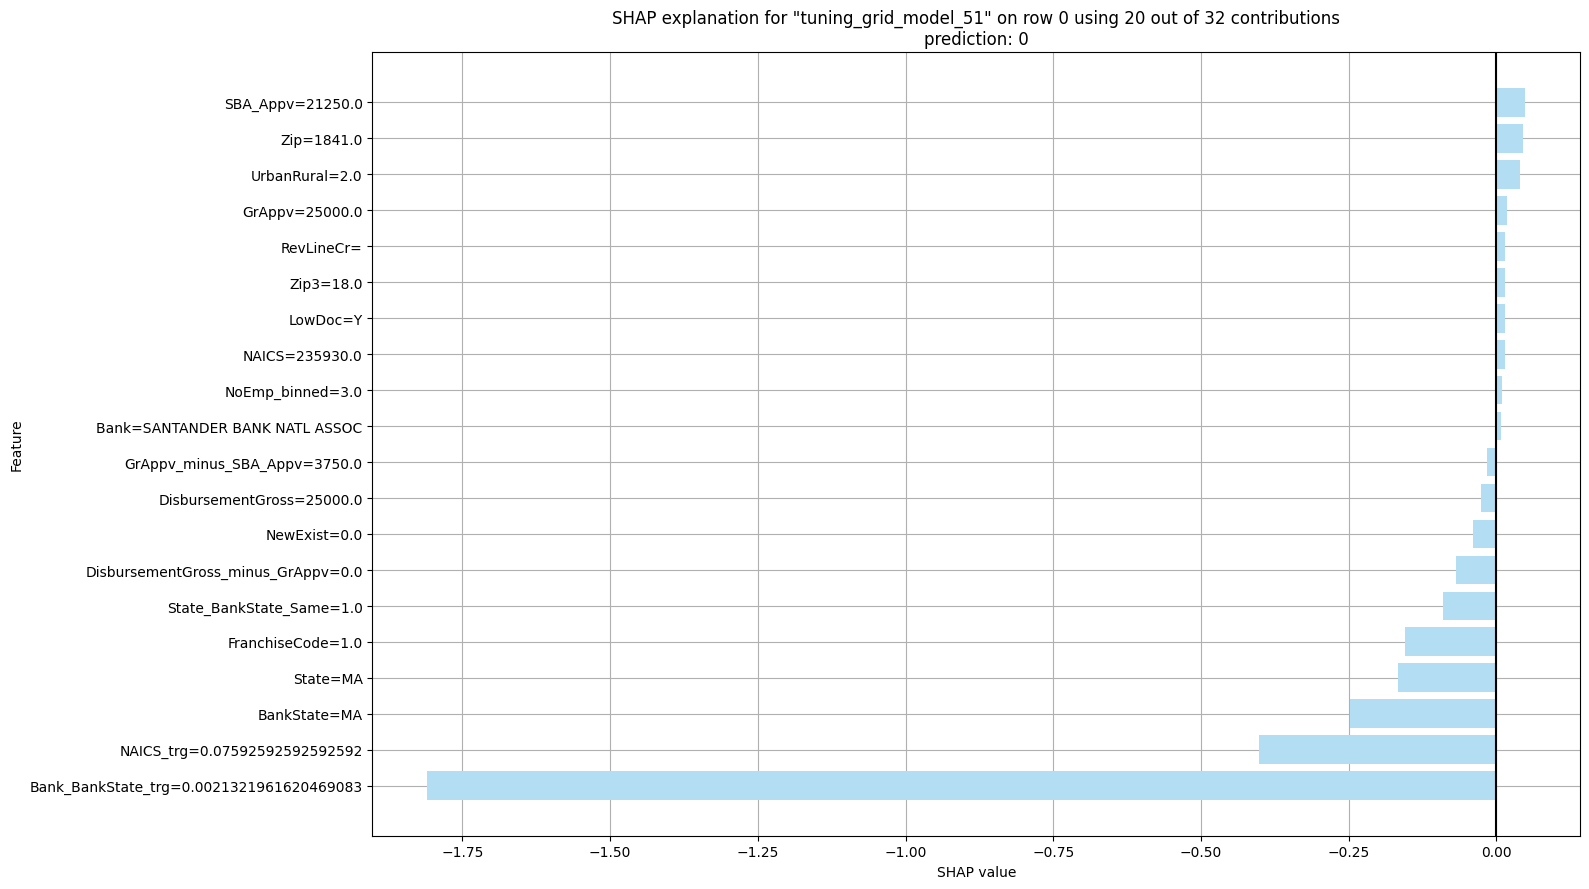

In [189]:
best_model.shap_explain_row_plot(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].head(2), row_index=0);

For this observation which was incorrectly identified by the model,

1. Bank_BankState_trg = 0.002
2. NAICS_trg = 0.0759

are the contributing features that lowered the probability of default.

The loan issuing bank 'SANTANDER BANK NATL ASSOC_MA' has a very good track record.

NAICS_trg is also low, which further made the model to lower the probablility of a default.

BUT, this case seems to be a exception to the trends that were identified by our model, and the loan was actually deafulted.

# Residual Analysis

Our objective is to find the predictors and any trends, patterns, etc that suggest a higher residual value.

# Residual Analysis where the model misclassified a Non-Defaulting entity as Defaulter.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

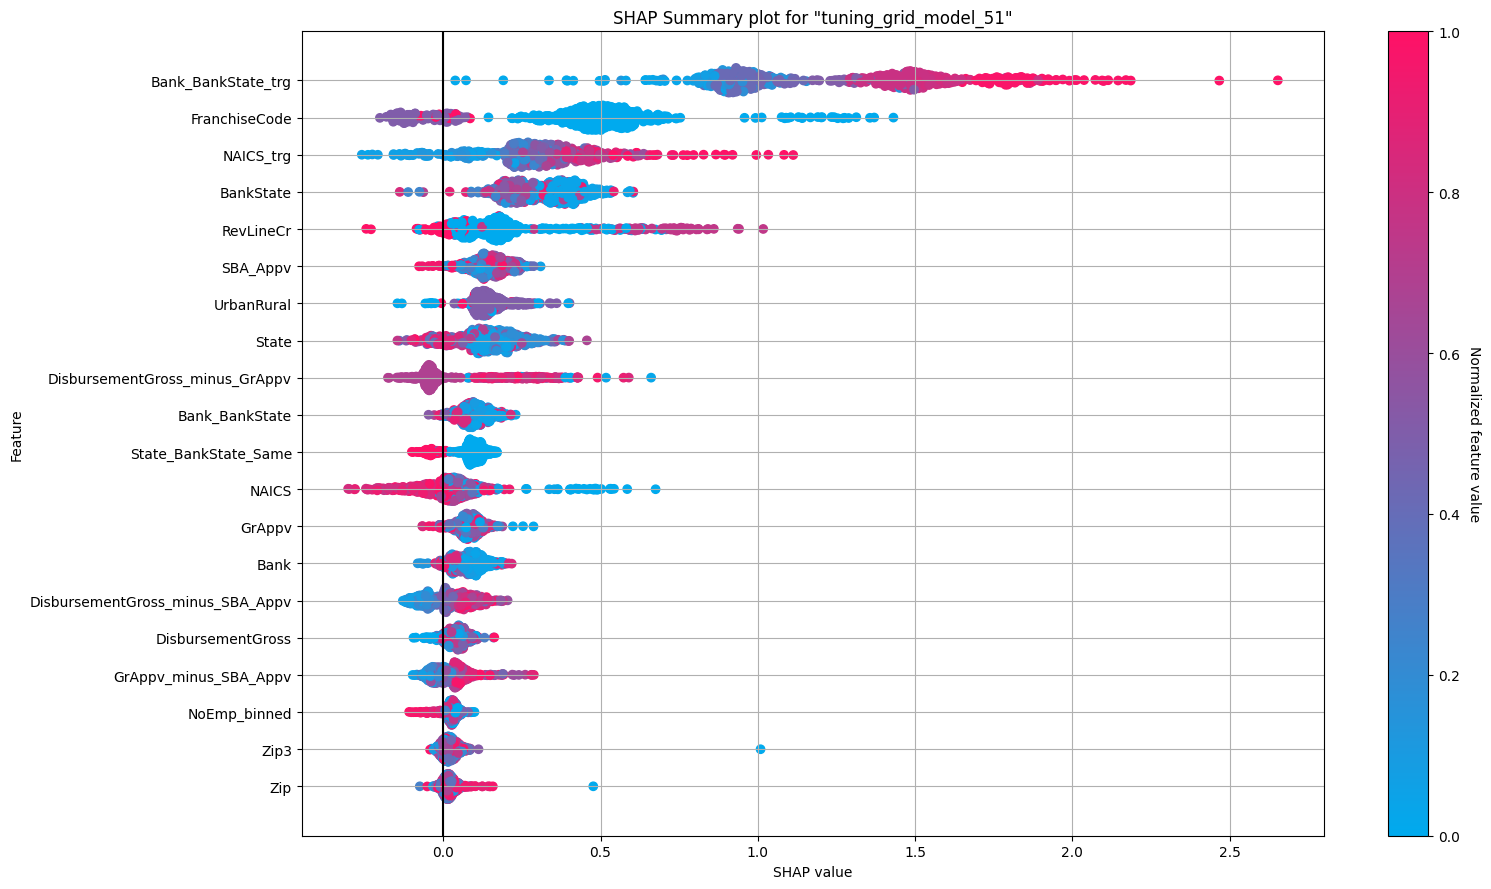

In [29]:
best_model.explain(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 0].tail(500),include_explanations =['shap_summary']);

## Common Patterns in Errors.

As is clearly visible from the shapley values, some of the important features in our best model are the same features that have contributed to the errors in our model predictions.

The features that contribute most to the errors are:

1. Bank_BankState_trg
2. FranchiseCode
3. NAICS_trg

These all Non-defaulting loans are from banks that have a high mean target encoded default response. Therefore following the trend, the model marked them with high probability of deafult.

From FranchiseCode, it is evident that most of these Non-Defaulting businesses do not have a franchise, therefore the model marked these loans as risky, but these loans, in actuality did not default.

Similar to Bank_BankState_trg, NAICS_trg shows us that these all cases are mostly from NAICS sectors that are prone to high default rates, but these particular cases, even though belonging to risky NAICS, did not default on thier loans. 

These points that were actually non-defaulters, have all the traits of an entity that has a good chance of default, but are an exception to the trends that were identified by the model.



# Residual Analysis where the model misclassified a Defaulting entity as Non-Defaulter.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

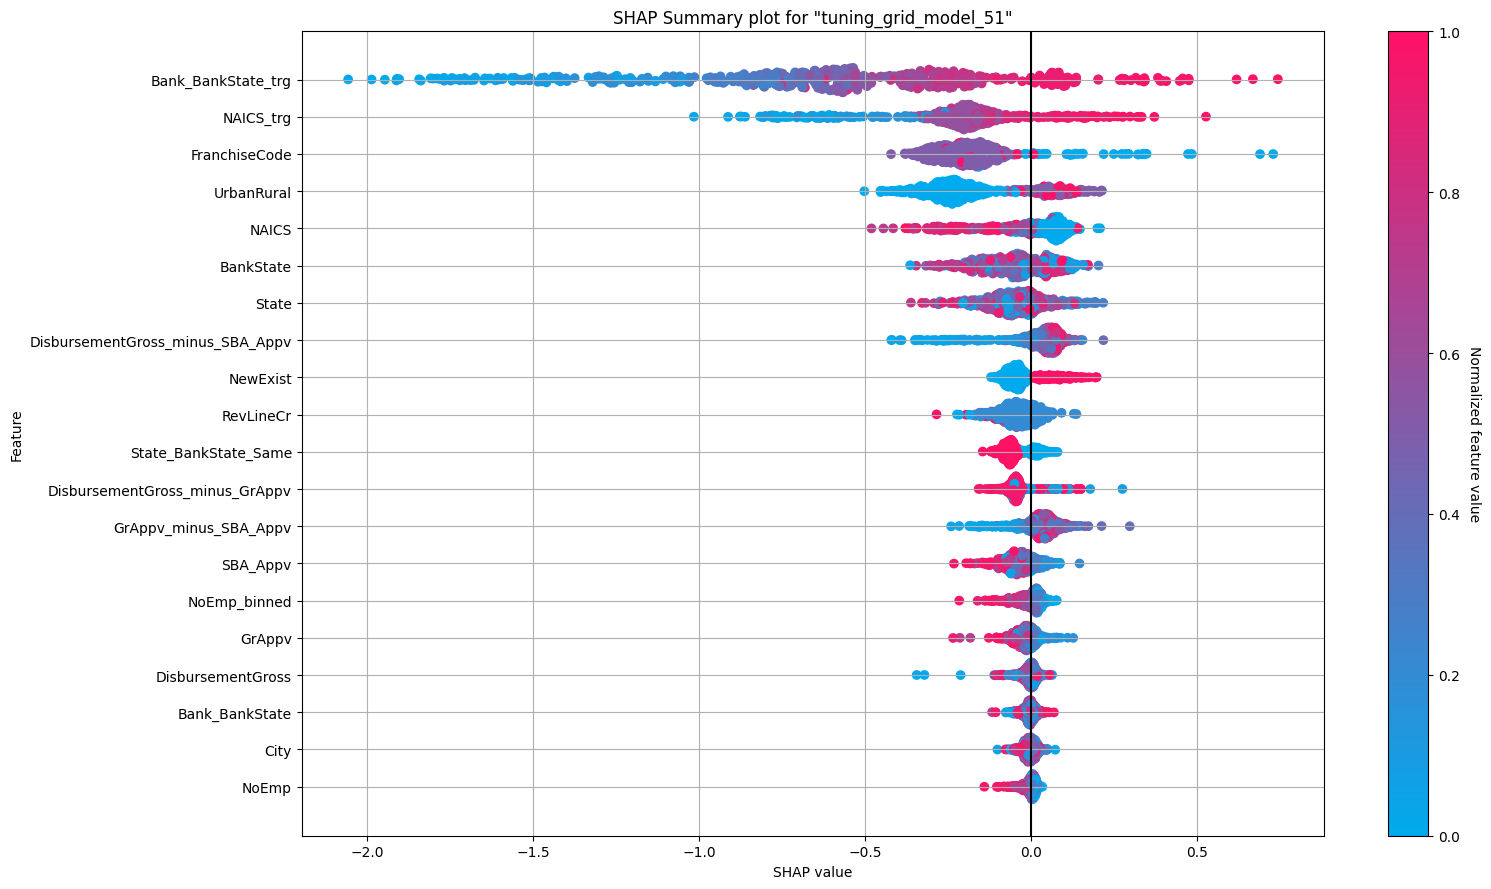

In [30]:
best_model.explain(h2o_test_df_sorted[h2o_test_df_sorted["MIS_Status"] == 1].head(500),include_explanations =['shap_summary']);

## Common Patterns in Errors.

As is clearly visible from the shapley values, some of the important features in our best model are the same features that have contributed to the errors in our model predictions.

The features that contribute most to the errors are:

1. Bank_BankState_trg
2. NAICS_trg
3. FranchiseCode

These all Defaulting loans are from banks that have a low mean target encoded default response. Therefore following the trend, the model marked them with low probability of deafult.

These all Defaulting loans are from customers that have multiple franchises, and generally, businesses with franchises do not default on thier loans.

Similar to Bank_BankState_trg, NAICS_trg shows us that these all cases are mostly from NAICS sectors that have low default rates, but these particular cases, even though belonging to low-risk NAICS, did default on thier loans.


These points that were actually defaulters, have all the traits of an entity that has a good chance of not defaulting on the loan, but are an exception to the trends that were identified by the model.

# Storing the Artifacts.

These artifacts will be furthur utilized in the Scoring Function.


In [15]:
artifacts_dict = {
    "categorical_encoders": categorical_encoders,
    "to_categorical": to_categorical,
    "columns_to_trg_encode": columns_to_trg_encode,
    "h2o_threshold": h2o_threshold,
    "bin_edges_dict": bin_edges_dict,
    "numerical_cols_to_cat": numerical_cols_to_cat,
    "numerical_to_categorical": numerical_to_categorical
}
artifacts_project_2 = open("./artifacts/artifacts_project_2.pkl", "wb")
pickle.dump(obj=artifacts_dict, file=artifacts_project_2)

artifacts_project_2.close()

model_path = h2o.save_model(model=best_model, path="./artifacts/best_model_project_2", force=True)
print(f"Model saved to: {model_path}")

Model saved to: C:\Users\skane\virtualenvn\notebooks\artifacts\best_model_project_2\tuning_grid_model_51


In [16]:
h2o.cluster().shutdown()

H2O session _sid_90fe closed.


## Project Summary and Conclusion


**Summary of the work:**

In the above project, we have tried to implement a GBM model on the SBA_Loan dataset. This dataset contains information regarding the various businesses, of which some have defaulted on their loans.

Using the data provided, we have come up with a model that will help us, based on the available data to identify any future businesses that apply for a loan from the banks, and are at a high risk of default.

Our model is capable of giving out a probability of defaulting for each case. And based on this probability, the banks can take extra measures before offering loans in the future.

The GBM is a non-linear model, which tries to find criteria that can best separate our datapoints. Given that we consistently got an AUC
score of around 0.85 across datasets from our best model, we can conclude that the model will be able to flag a good chunk of business loan applications in the future that may be at a risk of defaulting on the loan.


**Summary of the findings:**

Features like Bank_BankState_trg, NAICS_trg, FranchiseCode and UrbanRural are particularly important features.

Bank_BankState_trg: This tells us that there are some banks that are more likely to give out risky loans, and hence have a high default numbers among their customers.

NAICS_trg: Some sectors of the economy are particularly prone to high default rates. These should be considered while giving out any loan to a business.

FranchiseCode: Whether a particular business has multiple franchises is a strong indicator when it comes to loan default likelihood. Multiple franchises indicate lower default rates.

UrbanRural: Another feature that helps seperate the defaulting and non-defaulting banks is UrbanRural.


**Summary of Model Performance:**

The model consistently gave an AUC of ~0.85. Therefore it has performed decently on the imbalanced data. The model is able to identify the non-linear patterns in the data very well.

The GBM, which is a tree based boosting model, can provide good interpretability using shapley values. We can monitor the behaviour of the model on a global scale as well as on a per case basis.

However, because the model is utilizing the mean target response of Bank_BankState variable and NAICS, the model is judging individual datapoints based on the global nature of these features. This has lead to the model misclassifying defaulters to non-defaulters and vice-versa.

**Summary of Recommendations:**

More data is always helpful. From a domain understanding, more of the financial records of the businesses can greatly help us to achieve this task of classifying between businesses that may and may not default. Time based business related data, loan related data, the federal reserve interest rates, loan repayment history, etc can also help us track the likelihood of a default.

Based on the NAICS Sector, UrbanRural value or physical location of the loan applicant, we can have multiple models to better perform for each subset of the market.